In [1]:
import dgl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import spatial
import scipy.spatial.distance as dist
import networkx as nx
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import torch


import torch.nn as nn
import torch.nn.functional as F


In [2]:
feats = h5py.File('/cosma5/data/dp004/dc-cues1/features/halo_features_s99','r+')    

In [3]:
positions = feats['Pos'][:]

In [4]:
np.max(positions)

302627.625

In [4]:
tree = spatial.cKDTree(positions)

In [5]:
edgeList = tree.query_pairs(2000) # within 2 Mpc

In [62]:
src, dst = zip(*edgeList)


G = dgl.DGLGraph()
G.add_nodes(len(positions))
G.add_edges(src, dst)

In [63]:
G

DGLGraph(num_nodes=290605, num_edges=261230,
         ndata_schemes={}
         edata_schemes={})

In [7]:
features = np.column_stack([feats['M200c'][:], 
                    feats['R200c'][:],
                    feats['N_subhalos'][:],
                    feats['VelDisp'][:],
                    feats['Vmax'][:],
                    feats['Spin'][:],
                    feats['Fsub'][:],
                    feats['x_offset'][:]])

In [8]:
# Add features to graph

G.ndata['feat'] = features

In [9]:
G.ndata

{'feat': array([[1.53578998e+15, 2.43272192e+03, 1.17480000e+04, ...,
        6.37112069e+00, 3.48616327e-01, 8.82196241e-01],
       [1.30734013e+15, 2.30565967e+03, 6.16000000e+03, ...,
        2.01060338e+00, 1.47057836e-01, 3.75705975e-02],
       [1.03331437e+15, 2.13168506e+03, 4.82800000e+03, ...,
        2.36017459e+00, 1.14615536e-01, 8.20239847e-02],
       ...,
       [1.01494473e+11, 9.83534927e+01, 1.00000000e+00, ...,
        3.95272678e+00, 4.50962793e-03, 1.95579142e-02],
       [1.00120936e+11, 9.79112854e+01, 1.00000000e+00, ...,
        6.01973285e+00, 1.08368904e-02, 2.18780777e-02],
       [1.00323328e+11, 9.79769821e+01, 1.00000000e+00, ...,
        4.56604535e+00, 2.33106610e-03, 2.39924625e-02]])}

In [10]:
G_nx = nx.from_edgelist(edgeList)

SGs_nx = list(nx.connected_component_subgraphs(G_nx))

In [11]:
SGs = [G.subgraph(SG_nx.nodes()) for SG_nx in SGs_nx]

In [12]:
SGs[0].ndata

{}

In [13]:
SGs[0].nodes()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [14]:
SGs[0].edges()

(tensor([0, 0, 2, 2, 2, 5, 5, 5, 6, 7]),
 tensor([1, 8, 4, 3, 8, 1, 0, 8, 8, 1]))

In [15]:
SGs[0].parent_nid

tensor([152008, 160937,  39692, 160494,  82351, 136561, 115956,  65175, 203674])

In [16]:
# Looks like we lost the features from parent graph...

#for sg in SGs:
#    sg.ndata['feat'] = features[sg.parent_nid, : ]

In [17]:
SGs[0].ndata

{}

In [18]:
#Visualization

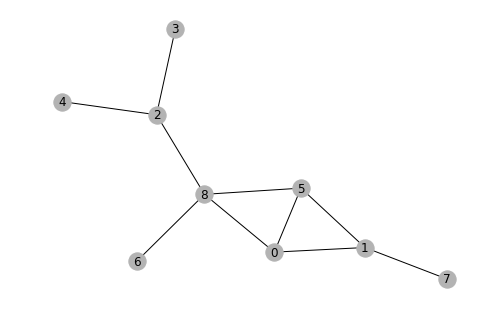

In [19]:
nx_G = SGs[0].to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [20]:
# Add pairwise distance (d, alpha) as edge feature

In [21]:
# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [42]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(features.shape[-1], 5, 1)

In [65]:
labels = torch.tensor(feats['Ngals'][:]).float().unsqueeze(-1)

In [66]:
labels.shape

torch.Size([290605, 1])

In [67]:
print(features.shape)

(290605, 8)


In [68]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G,  torch.tensor(features).float())
    # we save the logits for visualization later
    all_logits.append(logits.detach())

    criterion = nn.MSELoss()

    loss = criterion(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))


Epoch 0 | Loss: 3276089178080673792.0000
Epoch 1 | Loss: 3276089178080673792.0000


KeyboardInterrupt: 

In [5]:
feats.close()